<a href="https://colab.research.google.com/github/kutaydemiralay/Lane-Changing-Using-Controller-Design-with-Torque-Vectoring-and-Rear-Wheel-Steering/blob/main/LaneChange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy matplotlib cvxpy


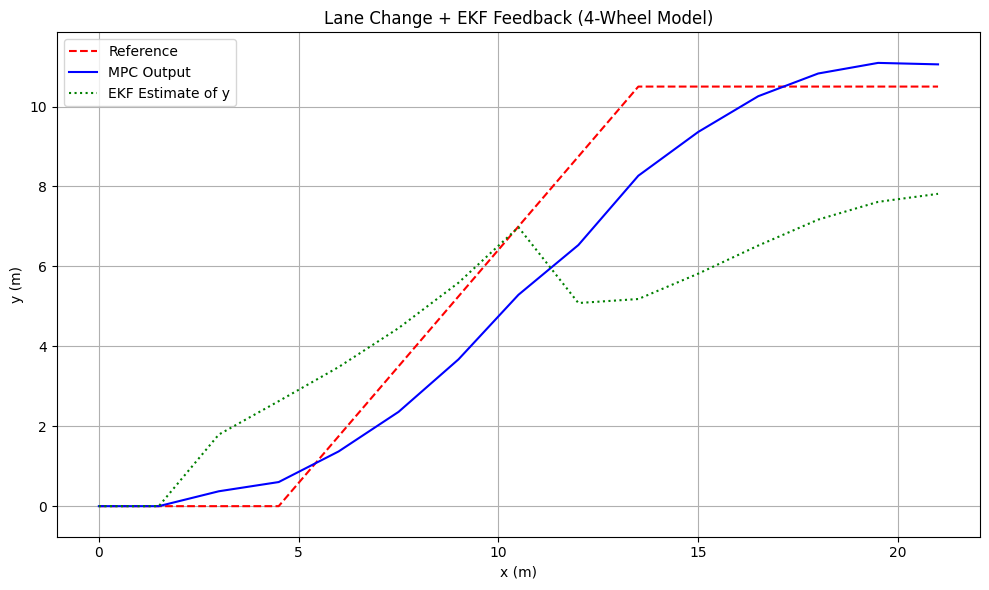

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# === Vehicle Parameters ===
N = 14
dt = 0.1
v_long = 15.0
a = 1.2
b = 1.3
m = 1500.0
Iz = 3000.0
Cf = 80000.0
Cr = 80000.0
delta_max = np.deg2rad(20)
w_delta = 0.1

# === Initial Conditions ===
y0, psi0, vy0, r0 = 0.0, 0.0, 0.0, 0.0
x0 = np.array([vy0, r0, y0, psi0])

# === Reference Trajectory ===
x_ref = np.linspace(0, N * dt * v_long, N + 1)
y_ref = np.zeros(N + 1)
hold_steps = 3
transition_length = 9.0
y_final = 10.5
for k in range(hold_steps, N + 1):
    dx = x_ref[k] - x_ref[hold_steps]
    if dx <= transition_length:
        y_ref[k] = (dx / transition_length) * y_final
    else:
        y_ref[k] = y_final

# === Dynamics Coefficients ===
A11 = -(2 * Cf + 2 * Cr) / (m * v_long)
A12 = -v_long - (2 * Cf * a - 2 * Cr * b) / (m * v_long)
A21 = -(2 * Cf * a - 2 * Cr * b) / (Iz * v_long)
A22 = -(2 * Cf * a**2 + 2 * Cr * b**2) / (Iz * v_long)
B1 = 2 * Cf / m
B2 = 2 * Cf * a / Iz

A_d = np.array([
    [1 + dt * A11, dt * A12, 0, 0],
    [dt * A21, 1 + dt * A22, 0, 0],
    [dt, dt * v_long, 1, 0],
    [0, dt, 0, 1]
])
B_d = np.array([[dt * B1], [dt * B2], [0], [0]])

# === EKF Setup ===
Q = np.diag([0.01, 0.01, 0.01, 0.01])   # Process noise
R = np.diag([0.05, 0.05])               # Measurement noise: y and psi
P = np.eye(4) * 0.1                     # Initial covariance
x_est = x0.copy()
estimates = [x_est.copy()]

# === MPC Setup ===
vy = cp.Variable(N + 1)
r = cp.Variable(N + 1)
y = cp.Variable(N + 1)
psi = cp.Variable(N + 1)
delta = cp.Variable(N)
cost = 0
constraints = []

# Apply constraints and cost
for k in range(N):
    cost += 2 * cp.square(y[k+1] - y_ref[k+1]) + w_delta * cp.square(delta[k])
    constraints += [vy[k+1] == vy[k] + dt * (A11 * vy[k] + A12 * r[k] + B1 * delta[k])]
    constraints += [r[k+1] == r[k] + dt * (A21 * vy[k] + A22 * r[k] + B2 * delta[k])]
    constraints += [y[k+1] == y[k] + dt * (vy[k] + v_long * psi[k])]
    constraints += [psi[k+1] == psi[k] + dt * r[k]]
    constraints += [cp.abs(delta[k]) <= delta_max]

# Initial condition constraints (from EKF)
constraints += [vy[0] == x_est[0], r[0] == x_est[1], y[0] == x_est[2], psi[0] == x_est[3]]

# === Solve Optimization ===
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve()

# === Simulate EKF with optimal inputs ===
u_opt = delta.value
for k in range(N):
    # Predict
    x_pred = A_d @ x_est + B_d.flatten() * u_opt[k]
    P_pred = A_d @ P @ A_d.T + Q

    # Measurement: only y and psi are "measured"
    z = np.array([y.value[k+1], psi.value[k+1]])
    H = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1]])
    y_tilde = z - H @ x_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    # Update
    x_est = x_pred + K @ y_tilde
    P = (np.eye(4) - K @ H) @ P_pred
    estimates.append(x_est.copy())

# === Plot Results ===
estimates = np.array(estimates)
plt.figure(figsize=(10, 6))
plt.plot(x_ref, y_ref, 'r--', label='Reference')
plt.plot(x_ref, y.value, 'b-', label='MPC Output')
plt.plot(x_ref, estimates[:, 2], 'g:', label='EKF Estimate of y')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Lane Change + EKF Feedback (4-Wheel Model)')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()


In [49]:
# === Compute Average Absolute Lateral Error ===
avg_abs_lateral_error = np.mean(np.abs(y.value - y_ref))
print(f"Average Absolute Lateral Error: {avg_abs_lateral_error:.4f} meters")


Average Absolute Lateral Error: 0.8719 meters


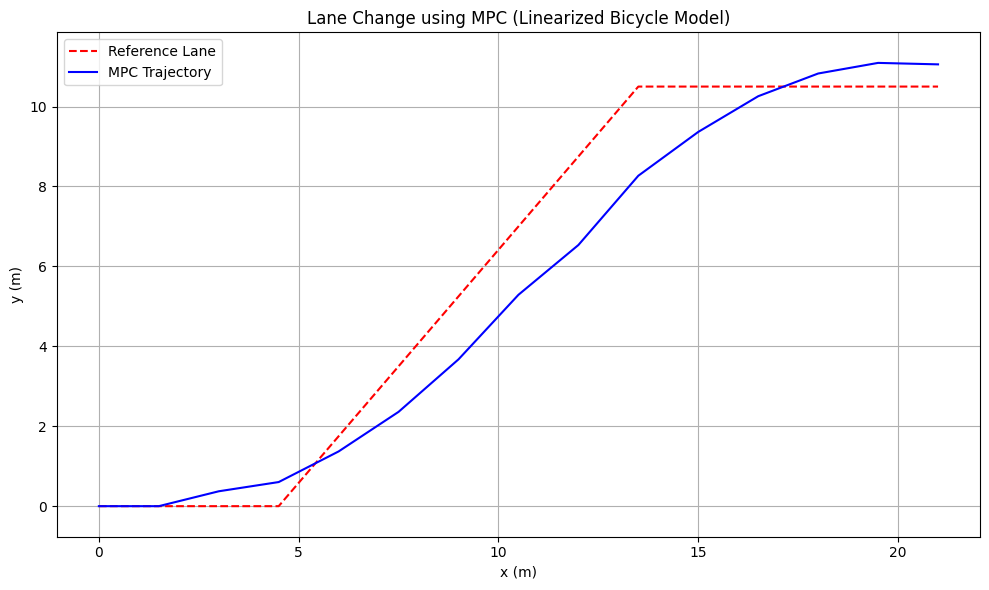

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# === Vehicle Parameters ===
N = 14             # Prediction steps
dt = 0.1            # Time step (s)
v_long = 15.0       # Longitudinal speed (m/s)
a = 1.2             # CG to front axle (m)
b = 1.3             # CG to rear axle (m)
m = 1500.0          # Mass (kg)
Iz = 3000.0         # Yaw inertia (kg·m²)
Cf = 80000.0        # Front cornering stiffness (N/rad)
Cr = 80000.0        # Rear cornering stiffness (N/rad)
delta_max = np.deg2rad(20)  # Max steering (rad)
w_delta = 0.1       # Weight on steering effort

# === Initial Conditions ===
y0 = 0.0
psi0 = 0.0
vy0 = 0.0
r0 = 0.0


# === Reference Trajectory ===
x_ref = np.linspace(0, N * dt * v_long, N + 1)
y_ref = np.zeros(N + 1)

# Parameters for reference shaping
hold_steps = 3             # steps to stay at y=0
transition_length = 9.0   # meters for lane change
y_final = 10.5              # target lane center

for k in range(hold_steps, N + 1):
    dx = x_ref[k] - x_ref[hold_steps]  # progress after hold ends
    if dx <= transition_length:
        y_ref[k] = (dx / transition_length) * y_final  # linear transition
    else:
        y_ref[k] = y_final  # hold at y=3.5 after transition


# === Define Optimization Variables ===
vy = cp.Variable(N + 1)
r = cp.Variable(N + 1)
y = cp.Variable(N + 1)
psi = cp.Variable(N + 1)
delta = cp.Variable(N)

# === Cost & Constraints ===
cost = 0
constraints = []

# Linearized dynamics at constant v_long
A11 = -(2 * Cf + 2 * Cr) / (m * v_long)
A12 = -v_long - (2 * Cf * a - 2 * Cr * b) / (m * v_long)
A21 = -(2 * Cf * a - 2 * Cr * b) / (Iz * v_long)
A22 = -(2 * Cf * a**2 + 2 * Cr * b**2) / (Iz * v_long)
B1 = 2 * Cf / m
B2 = 2 * Cf * a / Iz

for k in range(N):
    cost +=2 * cp.square(y[k+1] - y_ref[k+1]) + w_delta * cp.square(delta[k])

    constraints += [vy[k+1] == vy[k] + dt * (A11 * vy[k] + A12 * r[k] + B1 * delta[k])]
    constraints += [r[k+1] == r[k] + dt * (A21 * vy[k] + A22 * r[k] + B2 * delta[k])]
    constraints += [y[k+1] == y[k] + dt * (vy[k] + v_long * psi[k])]
    constraints += [psi[k+1] == psi[k] + dt * r[k]]
    constraints += [cp.abs(delta[k]) <= delta_max]

# Initial state
constraints += [vy[0] == vy0, r[0] == r0, y[0] == y0, psi[0] == psi0]

# === Solve the Problem ===
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve()

# === Plot the Results ===
plt.figure(figsize=(10, 6))
plt.plot(x_ref, y_ref, 'r--', label='Reference Lane')
plt.plot(x_ref, y.value, 'b-', label='MPC Trajectory ')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Lane Change using MPC (Linearized Bicycle Model)')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()


In [5]:
# === Compute Average Absolute Lateral Error ===
avg_abs_lateral_error = np.mean(np.abs(y.value - y_ref))
print(f"Average Absolute Lateral Error: {avg_abs_lateral_error:.4f} meters")


Average Absolute Lateral Error: 0.8719 meters


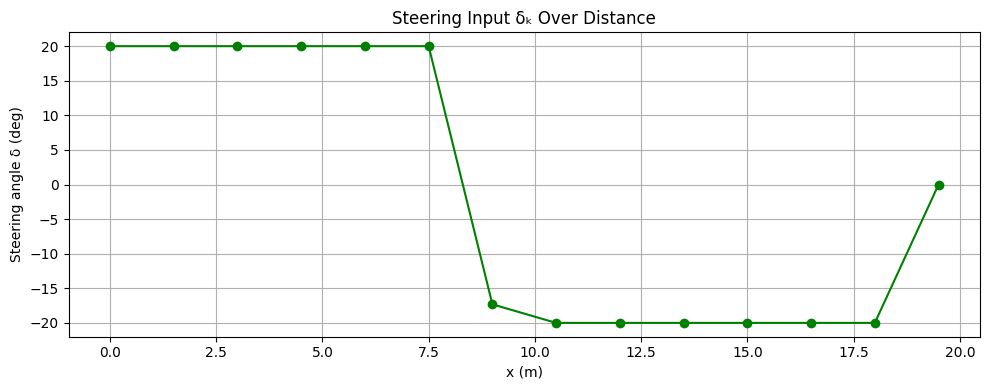

In [30]:
# Plot steering input over x_ref
plt.figure(figsize=(10, 4))
plt.plot(x_ref[:-1], np.rad2deg(delta.value), 'g-', marker='o')
plt.xlabel('x (m)')
plt.ylabel('Steering angle δ (deg)')
plt.title('Steering Input δₖ Over Distance')
plt.grid(True)
plt.tight_layout()
plt.show()


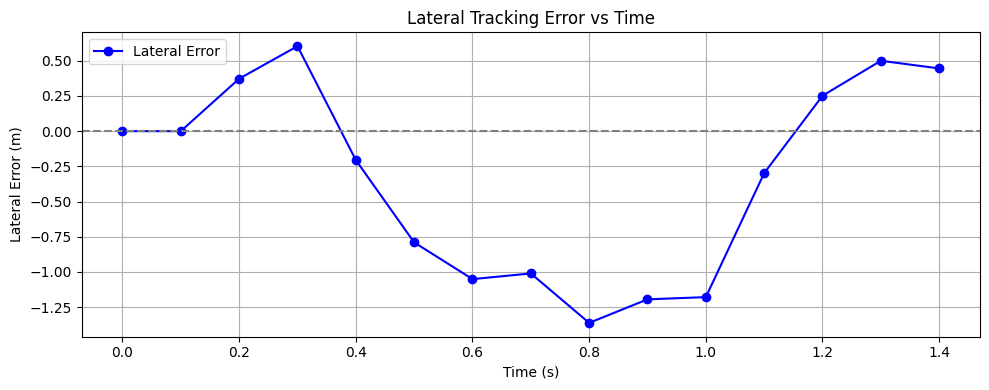

In [31]:
# === Compute and Plot Lateral Tracking Error ===
time = np.linspace(0, N * dt, N + 1)
lateral_error = y.value - y_ref  # elementwise difference

plt.figure(figsize=(10, 4))
plt.plot(time, lateral_error, 'b-', marker='o', label='Lateral Error')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Lateral Error (m)')
plt.title('Lateral Tracking Error vs Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Torque

In [32]:

total_steering_energy = np.sum(delta.value**2)


print(f"Total Steering Effort: {total_steering_energy:.4f}")



Total Steering Effort: 1.5535
